In [136]:
from collections import Counter
import dill
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('..')

from config import DATASET_DILL_OUTPUT_PATH, PROJECT_CONFIGS

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] =144

%config InlineBackend.figure_format = 'svg'


In [137]:
dill_path = os.path.join('..', DATASET_DILL_OUTPUT_PATH)
dill_path = '../output/results-selected-20240131.dill'

dataset_path = '../output/results-selected-20240131.csv'
project_configs = PROJECT_CONFIGS

In [138]:
with open(dill_path, 'rb') as f:
  results = dill.load(f)

In [139]:
ERROR_MAPPING = {
  'File not found': 'Missing File',
  'requires different compiler version' : 'Wrong Compiler Version',
  'SPDX license identifier' : 'Missing license',
  'Only state variables or file-level variables can have a docstring': 'Invalid Docstring',
  'Stack too deep': 'Stack too deep',
  'Error: Expected': 'Syntax',
  'Documentation tag @custom:attribution not valid for contracts.': 'Invalid Documentation Tag',
  'Internal compiler error': 'Internal Compiler Error',
  'Interfaces cannot inherit': 'Interfaces Cannot Inherit',
  'not found or not visible after argument-dependent lookup': 'Method Not Found',
  'Location has to be calldata for external functions': 'Location Must Be Calldata',
}

In [140]:
errors_by_project = {}
errors = []
for result in results:
  fs = [str(f[1]) for f in result.failures]
  errs = []
  for f in fs:
    for match, cat in ERROR_MAPPING.items():
      if match in f:
        errs.append(cat)
  
  errors += errs
  errors_by_project[result.project_name] = Counter(errs)
errors = Counter(errors)

/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype i

Text(0, 0.5, 'Num Files')

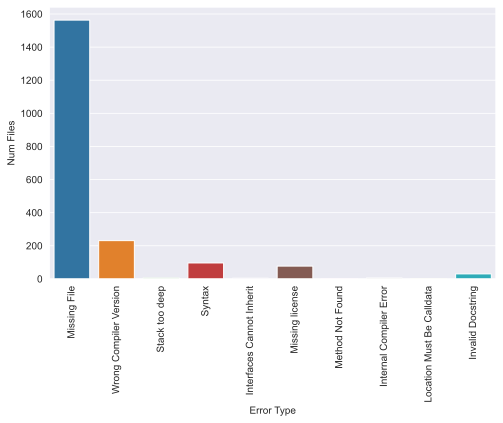

In [141]:
ax = sns.barplot(x=list(errors.keys()), y=list(errors.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_xlabel('Error Type')
ax.set_ylabel('Num Files')


# Annotate Dataset

In [142]:
df = pd.read_csv(dataset_path)
df['num_files_including_failures'] = df.num_files + df.num_failures

# add missing files info
missing_files_by_project = [{'project_name': k, 'num_failures_missing': v['Missing File']} for k, v in errors_by_project.items()]
mf = pd.DataFrame.from_records(missing_files_by_project)
df = df.merge(mf, on='project_name')
df['num_files_overall'] = df.num_files + df.num_failures
df['num_failures_not_missing'] = df.num_failures - df.num_failures_missing

df['frac_successes_overall'] = df.num_files / df.num_files_overall
df['frac_failures_overall'] = df.num_failures / df.num_files_overall
df['frac_failures_missing'] = df.num_failures_missing / df.num_failures
df['frac_failures_missing_overall'] = df.num_failures_missing / df.num_files_overall
df['frac_failures_not_missing_overall'] = df.frac_failures_overall - df.frac_failures_missing_overall

# add num repos info

num_repos_by_project = [{'project_name': p.name, 'num_repos': len(p.repo_urls)} for p in PROJECT_CONFIGS]
r = pd.DataFrame.from_records(num_repos_by_project)
df = df.merge(r, on='project_name')
df

,project_name,num_files,num_contracts,num_libraries,num_interfaces,num_functions,num_failures,cc_total,cc_mean,cc_median,...,num_files_including_failures,num_failures_missing,num_files_overall,num_failures_not_missing,frac_successes_overall,frac_failures_overall,frac_failures_missing,frac_failures_missing_overall,frac_failures_not_missing_overall,num_repos
0,Tether USDt,1,9,1,0,107,0,169,1.579439,1.0,...,1,0,1,0,1.000000,0.000000,NaN,0.000000,0.000000,1
1,USDC,23,25,9,4,130,31,159,1.223077,1.0,...,54,31,54,0,0.425926,0.574074,1.000000,0.574074,0.000000,1
2,Polygon,34,70,3,19,523,69,695,1.328872,1.0,...,103,64,103,5,0.330097,0.669903,0.927536,0.621359,0.048544,1
3,Chainlink,332,296,213,484,8612,122,14235,1.652926,2.0,...,454,47,454,75,0.731278,0.268722,0.385246,0.103524,0.165198,1
4,Toncoin,5,2,0,6,42,2,66,1.571429,2.0,...,7,0,7,2,0.714286,0.285714,0.000000,0.000000,0.285714,1
5,Shiba Inu,34,70,3,19,522,69,694,1.329502,1.0,...,103,64,103,5,0.330097,0.669903,0.927536,0.621359,0.048544,1
6,Dai,31,39,0,86,715,5,1148,1.605594,1.0,...,36,5,36,0,0.861111,0.138889,1.000000,0.138889,0.000000,13
7,Uniswap,53,49,155,124,1663,16,3878,2.331930,2.0,...,69,0,69,16,0.768116,0.231884,0.000000,0.000000,0.231884,1
8,Lido DAO,47,42,34,16,632,74,995,1.574367,1.0,...,121,73,121,1,0.388430,0.611570,0.986486,0.603306,0.008264,1
9,Immutable,14,2,3,13,156,37,302,1.935897,2.0,...,51,37,51,0,0.274510,0.725490,1.000000,0.725490,0.000000,1


/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Num Repos')

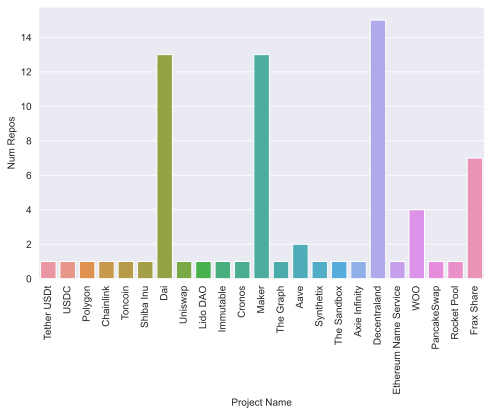

In [143]:
ax = sns.barplot(df, x='project_name', y='num_repos')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_xlabel('Project Name')
ax.set_ylabel('Num Repos')

In [71]:
df

,project_name,num_files,num_contracts,num_libraries,num_interfaces,num_functions,num_failures,cc_total,cc_mean,cc_median,...,loc_total,loc_mean_file,loc_median_file,num_files_including_failures,num_failures_missing,frac_failures_are_missing,frac_failures,frac_failures_missing,frac_failures_not_missing,num_repos
0,Tether USDt,1,9,1,0,107,0,169,1.579439,1.0,...,323,323.000000,323.0,1,0,NaN,0.000000,0.000000,0,1
1,USDC,23,25,9,4,130,31,159,1.223077,1.0,...,738,32.086957,31.0,54,31,1.000000,0.574074,0.574074,0,1
2,Polygon,34,70,3,19,523,69,695,1.328872,1.0,...,1893,55.676471,23.5,103,64,0.927536,0.669903,0.621359,5,1
3,Chainlink,332,296,213,484,8612,122,14235,1.652926,2.0,...,20162,60.728916,25.5,454,47,0.385246,0.268722,0.103524,75,1
4,Toncoin,5,2,0,6,42,2,66,1.571429,2.0,...,278,55.600000,25.0,7,0,0.000000,0.285714,0.000000,2,1
5,Shiba Inu,34,70,3,19,522,69,694,1.329502,1.0,...,1893,55.676471,23.5,103,64,0.927536,0.669903,0.621359,5,1
6,Dai,31,39,0,86,715,5,1148,1.605594,1.0,...,4851,156.483871,135.0,36,5,1.000000,0.138889,0.138889,0,13
7,Uniswap,53,49,155,124,1663,16,3878,2.331930,2.0,...,2272,42.867925,19.0,69,0,0.000000,0.231884,0.000000,16,1
8,Lido DAO,47,42,34,16,632,74,995,1.574367,1.0,...,2409,51.255319,28.0,121,73,0.986486,0.611570,0.603306,1,1
9,Immutable,14,2,3,13,156,37,302,1.935897,2.0,...,830,59.285714,26.0,51,37,1.000000,0.725490,0.725490,0,1


# Errors due to missing files

## Absolute numbers

/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

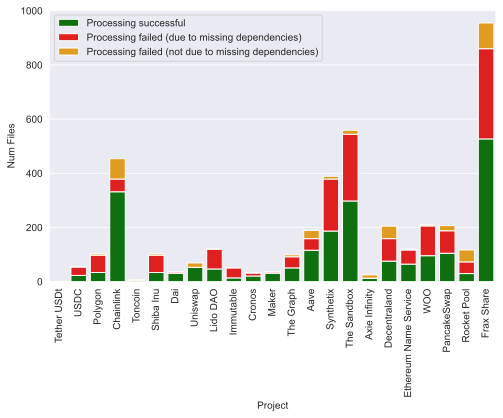

In [89]:
# Assuming df is your DataFrame and it has columns 'A', 'B', 'C' and 'project_name'
# Create bottom series (the one you want to be on the bottom of the stack)
bottom = df['num_files']
middle = df['num_failures_missing']
top = df['num_failures_not_missing']

ax = sns.barplot(x = 'project_name', y = 'num_files', data = df, color = 'green', label='Processing successful')
sns.barplot(x = 'project_name', y = 'num_failures_missing', data = df, bottom = bottom, color = 'red', label='Processing failed (due to missing dependencies)')
sns.barplot(x = 'project_name', y = 'num_failures_not_missing', data = df, bottom = bottom + middle, color = 'orange', label='Processing failed (not due to missing dependencies)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

ax.set_xlabel('Project')
ax.set_ylabel('Num Files')

plt.legend()
plt.show()

## Fraction

/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

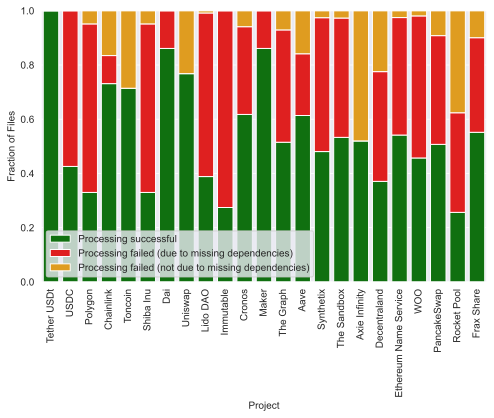

In [94]:
# Assuming df is your DataFrame and it has columns 'A', 'B', 'C' and 'project_name'
# Create bottom series (the one you want to be on the bottom of the stack)
B = 'frac_successes_overall'
M = 'frac_failures_missing_overall'
T = 'frac_failures_not_missing_overall'
bottom = df[B]
middle = df[M]
top = df[T]

ax = sns.barplot(x = 'project_name', y = B, data = df, color = 'green', label='Processing successful')
sns.barplot(x = 'project_name', y = M, data = df, bottom = bottom, color = 'red', label='Processing failed (due to missing dependencies)')
sns.barplot(x = 'project_name', y = T, data = df, bottom = bottom + middle, color = 'orange', label='Processing failed (not due to missing dependencies)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

ax.set_xlabel('Project')
ax.set_ylabel('Fraction of Files')

plt.legend()
plt.show()

In [120]:
from typing import Any, Optional
import re

def get_missing_filepath(err_msg: str) -> Optional[str]:
  lines = err_msg.split('\n')
  if len(lines) < 2:
    return
  match = re.search(r'"(.*?)"', err_msg)
  if match:
      file_path = match.group(1)
      return file_path

def notnull(ls: list[Optional[Any]]) -> list:
  return [e for e in ls if e is not None]


missing_files = []
for result in results:
  errs = [str(f[1]) for f in result.failures]
  missing_files += [get_missing_filepath(e) for e in errs if get_missing_filepath(e) is not None]

missing_dirs = [os.path.dirname(p) for p in missing_files]

print(f"Num missing files: {len(missing_files)}")
print(f"Num unique missing files: {len(set(missing_files))}")

print(f"Num missing dirs: {len(missing_dirs)}")
print(f"Num unique missing dirs: {len(set(missing_dirs))}")

missing_dir_roots = [p.split('/')[0] for p in missing_files]
print(f"Num missing dir roots: {len(missing_dir_roots)}")
print(f"Num unique missing dir roots: {len(set(missing_dir_roots))}")

set(missing_dir_roots)
Counter(missing_dir_roots).most_common(10)

Num missing files: 1679
Num unique missing files: 365
Num missing dirs: 1679
Num unique missing dirs: 212
Num missing dir roots: 1679
Num unique missing dir roots: 66


[('@openzeppelin', 741),
 ('@synthetixio', 191),
 ('project-repos', 167),
 ('openzeppelin-solidity', 127),
 ('@pancakeswap', 53),
 ('SPDX-License-Identifier: <SPDX-License>', 51),
 ('public', 42),
 ('frax-std', 36),
 ('@aave', 35),
 ('@aragon', 23)]

In [134]:
z_paths = [p for p in missing_files if 'openzeppelin' in p.lower()]
mcs = Counter(z_paths).most_common(20)

mcs = df.from_records([{'missing_path': path, 'count': count} for path, count in mcs])
mcs.style.background_gradient()

,missing_path,count
0,@openzeppelin/contracts/token/ERC20/IERC20.sol,106
1,@openzeppelin/contracts/math/SafeMath.sol,78
2,@openzeppelin/contracts/access/Ownable.sol,77
3,openzeppelin-solidity/contracts/ownership/Ownable.sol,32
4,@openzeppelin/contracts/token/ERC20/ERC20.sol,29
5,openzeppelin-solidity/contracts/token/ERC20/IERC20.sol,24
6,@openzeppelin/contracts/utils/introspection/IERC165.sol,20
7,openzeppelin-solidity/contracts/token/ERC20/ERC20.sol,19
8,openzeppelin-solidity/contracts/math/SafeMath.sol,19
9,@openzeppelin/contracts-upgradeable/utils/ContextUpgradeable.sol,18


In [135]:
len(z_paths)

901